In [320]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import opt_tugba
import sys
import os

/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [321]:
test = "3"

new_event = True 
time = 15
pow_max = 15
pow_min = 0
overstay_duration= 1
duration= 5
batt_cap= 80
SOC_init = 0.3
SOC_need= 0.8
lam_x = 0
event = {"time" : time, 
        "pow_min" : pow_min, 
        "pow_max" : pow_max, 
        "overstay_duration" : overstay_duration, 
        "duration" : duration, 
        "batt_cap" : batt_cap, 
        "SOC_need" : SOC_need, 
        "SOC_init" : SOC_init, 
        'eff':1.0}
tariff = np.ones((96,)) 
# tariff[40:50] = np.ones(shape = (10,)) * 2.5
# tariff[50:60] = np.ones(shape = (10,)) * 2.5
# tariff[60:70] = np.ones(shape = (10,)) * 5 
tariff[60:65] = np.ones(shape = (5,)) * 2.5
tariff[65:70] = np.ones(shape = (5,)) * 2.5
tariff[70:75] = np.ones(shape = (5,)) * 10
tariff[75:80] = np.ones(shape = (5,)) * 5
tariff[80:85] = np.ones(shape = (5,)) * 2.5



In [322]:
par = opt_tugba.Parameters(TOU = tariff, lam_x= lam_x)
prb = opt_tugba.Problem(par = par, event = event)
opt = opt_tugba.Optimization(par, prb)
res = opt.run_opt()

/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/aysetugbaozturk/minicon

Interpolated TOU Cost: [ 2.5  2.5  2.5  2.5  2.5  5.   5.   5.   5.   5.  10.  10.  10.  10.
 10.   5.   5.   5.   5.   5.   2.5  2.5  2.5  2.5]
Lam_X: 0
24 16 [ 2.5  2.5  2.5  2.5  2.5  5.   5.   5.   5.   5.  10.  10.  10.  10.
 10.   5.   5.   5.   5.   5.   2.5  2.5  2.5  2.5]
hello_test
u: [15.   15.   15.   15.   15.   10.85 10.85 10.85 10.85 10.85  0.    0.
  0.    0.    0.   10.85 10.85 10.85 10.85 10.85 15.   15.   15.   15.  ] SOC: [0.3  0.34 0.39 0.43 0.47 0.52 0.55 0.58 0.61 0.64 0.67 0.67 0.67 0.67
 0.67 0.67 0.7  0.73 0.77 0.8  0.83 0.87 0.91 0.96 1.  ]


In [323]:
        ### Read parameters 
        N_flex = prb.N_flex
        N_asap = prb.N_asap
        TOU = prb.TOU
        station_pow_max = prb.station_pow_max
        lam_x = par.lam_x
        lam_h_c = par.lam_h_c
        lam_h_uc = par.lam_h_uc
        user_SOC_init  =  prb.user_SOC_init
        user_SOC_need = prb.user_SOC_need
        delta_k = par.Ts
        eff = par.eff
        user_bat_cap = prb.user_batt_cap  
        print("Lam_X:",lam_x)
        print(N_flex, N_asap, lam_x, user_SOC_init, user_SOC_need,eff)
        objective = "J = u.T @ TOU + norm2 * {} + lam_h_c * 1 / z[2] \n + cp.sum(station_pow_max * (TOU[:N_asap] - z[1])) \n v[2] * cp.sum(TOU[:N_asap])".format(lam_x)

Lam_X: 0
24 16 0 0.3 1 0.92


/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [324]:
days = 0 
num_interval= len(par.TOU)
interval_size = par.Ts

timerange = pd.date_range("1/1/2021", periods=num_interval, freq="{}H".format(interval_size ))
TOU_cost = pd.Series(par.TOU, index = timerange, name = "TOU Cost ($)")


# Event parameters: arrival_time, soc_init, soc_need, departure
opt_time_start  = pd.Timestamp(year=2021, month=1, day=1, hour = int(res["time_start"] // 1), minute = int(60 * ( res['time_start'] % 1)))
opt_time_end_flex  =pd.Timestamp(year=2021, month=1, day=1, hour = int(res["time_end_flex"]  // 1),  minute = int(60 *(res['time_end_flex'] % 1)))
opt_time_end_asap  = pd.Timestamp(year=2021, month=1, day=1, hour = int(res["time_end_asap"] // 1), minute = int(60 *(res['time_end_asap'] % 1)))

flex_ts = pd.date_range(start=opt_time_start , end=opt_time_end_flex, freq="{}H".format(par.Ts))
asap_ts = pd.date_range(start=opt_time_start , end=opt_time_end_asap, freq="{}H".format(par.Ts))

# Optimization outputs 

## Question: Why flex output length mismatches the timelength? 
# print(opt.opt_flex_powers.shape)
opt_flex_powers = pd.Series(res['flex_powers'].reshape(len(res['flex_powers']),), index = flex_ts[:-1], name = "Flew Power (kWh)")
opt_asap_powers = pd.Series(res['asap_powers'].reshape(len(res['asap_powers']),), index = asap_ts[:-1], name = "ASAP Power (kWh)")
opt_flex_SOCs = pd.Series(res['flex_SOCs'].reshape(len(res['flex_SOCs']),), index = flex_ts, name = "Flex SOC (%)")
# event = prb.event
# print(event)




        

In [325]:
## PLOT FOR 2 days 
days =2 
ts = pd.date_range(timerange[0], periods=num_interval * days, freq="{}H".format(interval_size ))
df_plot = pd.DataFrame(index = ts, 
                        data = {"TOU Cost ($)": list(TOU_cost.values) * days, 
                        "Flex Power (kW)": opt_flex_powers, 
                        "ASAP Power (kW)":opt_asap_powers, 
                        "Flex SOC (%)":opt_flex_SOCs})

df_plot["Flex SOC (%)"] = df_plot["Flex SOC (%)"].fillna(method='bfill').fillna(method='ffill')
df_plot = df_plot.fillna(0)
df_plot['Station Max Power (kW)'] = event['pow_max']
df_plot['Station Min Power (kW)'] = event['pow_min']
df_plot['Arrival SOC'] = event['SOC_init']
df_plot['Departure SOC Demand'] = event['SOC_init'] + event['SOC_need']



def plot_arrival_departure(ax_list, event):
    for ax in ax_list:
        arrival_time = pd.Timestamp(year=2021, month=1, day=1, hour = int(event['time']// 1), minute = int(60 * ( event['time'] % 1)))
        departure_time = arrival_time + pd.Timedelta(hours = int(event['duration']// 1), minutes = int(60 * ( event['time'] % 1)))
        ax.axvspan(arrival_time, departure_time, facecolor='b', alpha=0.1)

def plot_max_min_power(ax_list, df_plot):
    for ax in ax_list:
        ax.plot(df_plot['Station Max Power (kW)'], label="Station Max Power (kW", color = 'red')
        # ax.plot(df_plot['Station Min Power (kW)'],label="Station Max Power (kW")))
def x_axis_labels(ax_list, cuts=[0,6,12,18]):
    import matplotlib.dates as mdates
    hlocator = mdates.HourLocator(byhour=cuts, interval=1, tz=None)
    for ax in ax_list:
        # ax.xaxis.set_major_locator(loc)
        ax.xaxis.set_major_locator(hlocator)
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%H"))

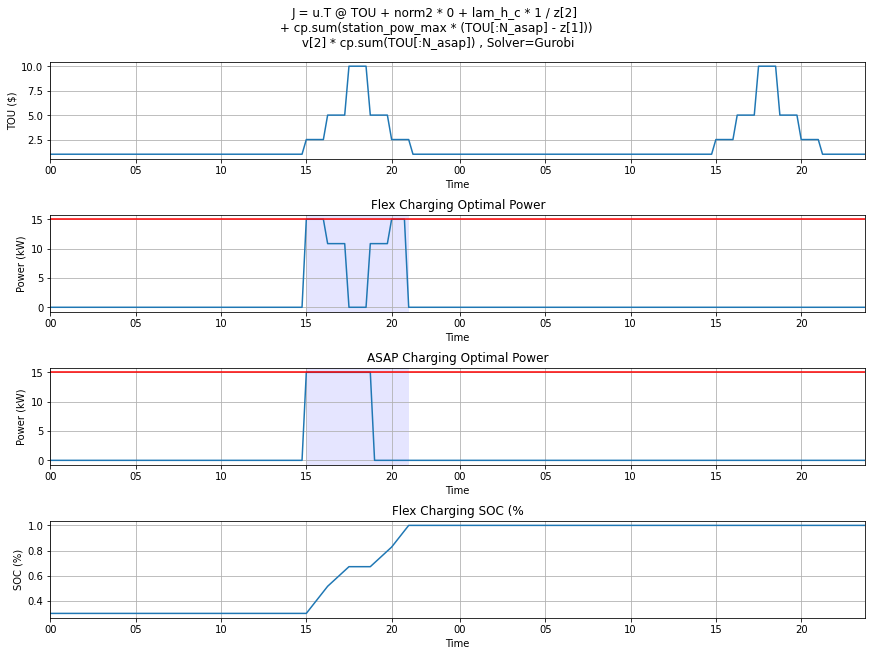

In [326]:
plt.rcParams['figure.constrained_layout.use'] = True

fig,(ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=(12,9) ,)

x_lim  = (list(df_plot.index)[0],list(df_plot.index)[-1])
ax1.plot(df_plot['TOU Cost ($)'])
ax1.set_xlim(x_lim)
ax1.grid()
ax1.set_xlabel("Time")
ax1.set_ylabel("TOU ($)")


ax2.plot(df_plot["Flex Power (kW)"])
ax2.set_xlim(x_lim)
ax2.grid()
ax2.set_xlabel("Time")
ax2.set_ylabel("Power (kW)")
ax2.set_title("Flex Charging Optimal Power")

ax3.plot(df_plot["ASAP Power (kW)"])
ax3.set_xlim(ax1.set_xlim(x_lim))
ax3.grid()
ax3.set_xlabel("Time")
ax3.set_ylabel("Power (kW)")
ax3.set_title("ASAP Charging Optimal Power")

ax4.plot(df_plot["Flex SOC (%)"])
ax4.set_xlim(x_lim)
ax4.grid()
ax4.set_xlabel("Time")
ax4.set_ylabel("SOC (%)")
ax4.set_title("Flex Charging SOC (%")

plot_arrival_departure([ax2,ax3], event)
plot_max_min_power([ax2,ax3], df_plot)
x_axis_labels([ax1,ax2,ax3,ax4], cuts=[0,5,10,15,20])
fig.suptitle("{} , Solver=Gurobi".format(objective))
plt.savefig(os.path.join("Figures/", "test_full_code_{}.pdf".format(test)),format='pdf')
plt.show()
plt.close()

In [327]:
df_plot.iloc[35:]

/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,TOU Cost ($),Flex Power (kW),ASAP Power (kW),Flex SOC (%),Station Max Power (kW),Station Min Power (kW),Arrival SOC,Departure SOC Demand
2021-01-01 08:45:00,1.0,0.0,0.0,0.3,15,0,0.3,1.3
2021-01-01 09:00:00,1.0,0.0,0.0,0.3,15,0,0.3,1.3
2021-01-01 09:15:00,1.0,0.0,0.0,0.3,15,0,0.3,1.3
2021-01-01 09:30:00,1.0,0.0,0.0,0.3,15,0,0.3,1.3
2021-01-01 09:45:00,1.0,0.0,0.0,0.3,15,0,0.3,1.3
...,...,...,...,...,...,...,...,...
2021-01-02 22:45:00,1.0,0.0,0.0,1.0,15,0,0.3,1.3
2021-01-02 23:00:00,1.0,0.0,0.0,1.0,15,0,0.3,1.3
2021-01-02 23:15:00,1.0,0.0,0.0,1.0,15,0,0.3,1.3
2021-01-02 23:30:00,1.0,0.0,0.0,1.0,15,0,0.3,1.3
